# Diabetic Retinopathy Classification
## Input:
##### 1) Set up connection of Google Colab to Google Drive
##### 2) Set up use of GPU for processing
##### 3) Set up directoy paths in the 'directory' object
##### 4) Step of move JPEG into automatically created directories must be done manually. Currently it is done by uploading all files in distinct folders which correspond to each class for training, and folders for validation

## Output:
##### 1) Trained Cross Entrophy Loss CNN model. Model on 15th epoch is saved.
##### 2) JSON file with Accuracy and Cross Entrophy Loss based on Training and Validation Set across 15 epochs

## Process Overview:
##### 566 Color JPEG images of 500 by 500 pixels for each disease class of 0, 1, 2, 3, and 4 is used to train a CNN model with cross entrophy loss. 566 images were used because the class with the smallest count was 566 from using all training zip files. The model was trained for 30 minutes, when 20 minutes is sufficient for highest validation set accuracy. A validation set of 144 images of each class is used. In this model the validation set is just used to give information on which epoch to use the model for, but the validation data does not train the model.

## Results:
##### Model has a validation set accuracy between 27% and 30% accuracy. Random quessing results in an accuracy of 20%. Close to state of the art models on Kaggle have an accuracy of between 60-75%. https://www.kaggle.com/c/diabetic-retinopathy-detection/notebooks

# Setup

In [1]:
# Keras
import keras
print(keras.__version__)
from keras import metrics

# File and Folder Management
import os, shutil

# Store history
import json

Using TensorFlow backend.


2.2.4






This notebook contains the code sample found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)

In [0]:
# Example of how to unzip files directly on google drive
# unzipped directly on gdrive. !unzip -qq dogs-vs-cats.zip, followed up by !unzip -qq train.zip and !unzip -qq test1.zip

In [2]:
!pwd

/content


In [3]:
!dir

sample_data


In [25]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [26]:
train_action = True

# Set directory
#aaron_dir = "/content/drive/My Drive/Colab Notebooks/SML_Project"
aaron_dir = '../SML_Project_Data'

directory = aaron_dir

In [6]:
!pwd
os.chdir(directory)
!ls

/Users/aaronmoskowitz/Documents/Diabetic-Retinopathy-Detection
data                train.zip.001       train.zip.005       train_002
data.zip            train.zip.002       trainLabels.csv     train_003
downsized_data      train.zip.003       trainLabels.csv.zip train_004
train               train.zip.004       train_001           train_005


In [0]:
#!apt-get install p7zip-full

#!p7zip -d data.zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/bin/p7zip: data.zip: unknown suffix


In [7]:
#!7za e data.zip

In [0]:
#!pip install h5py

#!pwd # just to see where you are, optional
# !ls -lt # just to see what is in that directory, optional
#!unzip -qq dogs-vs-cats.zip
# etc.

In [8]:
#!unzip -qq data.zip

In [9]:
#!unzip -qq train.zip
#!unzip -qq test1.zip

# Create Directories

In [10]:
# Directory of training data

original_base_dir = directory


base_dir = original_base_dir + "/data"

try:
    os.mkdir(base_dir)
except FileExistsError:
  print('Folder Already Exists \n')
else:
  print('Creating Folder \n')

Folder Already Exists 



In [11]:
history_dir = directory + '/history'

train_dir = os.path.join(directory, 'data', 'train')
val_dir = os.path.join(directory, 'data', 'val')
#test_dir = os.path.join(directory, 'data','test')

train_0_dir = os.path.join(train_dir, 'resized_0')
train_1_dir = os.path.join(train_dir, 'resized_1')
train_2_dir = os.path.join(train_dir, 'resized_2')
train_3_dir = os.path.join(train_dir, 'resized_3')
train_4_dir = os.path.join(train_dir, 'resized_4')

val_0_dir = os.path.join(val_dir, 'resized_0')
val_1_dir = os.path.join(val_dir, 'resized_1')
val_2_dir = os.path.join(val_dir, 'resized_2')
val_3_dir = os.path.join(val_dir, 'resized_3')
val_4_dir = os.path.join(val_dir, 'resized_4')

#test_cats_dir = os.path.join(test_dir, 'cats')
#test_dogs_dir = os.path.join(test_dir, 'dogs')

def create_folder(path):
  print('Looking to create folder of', path)
  try:
      os.mkdir(path)
  except FileExistsError:
    print('Folder Already Exists \n')
  else:
    print('Creating Folder \n')

In [12]:
# Store history files
history_dir = directory + '/history'
create_folder(history_dir)

Looking to create folder of ../SML_Project_Data/history
Creating Folder 



In [13]:
# Create all Train and Validate Folders in Data with Folders for Each Class
for data_type in ('train', 'val'):
  for disease in (0, 1, 2, 3, 4):
    path = directory + '/data/' + data_type + '/resized_' + str(disease)
    create_folder(path)

Looking to create folder of ../SML_Project_Data/data/train/resized_0
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/train/resized_1
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/train/resized_2
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/train/resized_3
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/train/resized_4
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/val/resized_0
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/val/resized_1
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/val/resized_2
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/val/resized_3
Folder Already Exists 

Looking to create folder of ../SML_Project_Data/data/val/resized_4
Folder Already Exists 



# Move Files into Directories (Not Done)

In [0]:
# Move files from one folder to another, didn't work, so did it manually
'''
# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)
'''

"\n# Copy first 1000 cat images to train_cats_dir\nfnames = ['cat.{}.jpg'.format(i) for i in range(1000)]\nfor fname in fnames:\n    src = os.path.join(original_dataset_dir, fname)\n    dst = os.path.join(train_cats_dir, fname)\n    shutil.copyfile(src, dst)\n\n# Copy next 500 cat images to validation_cats_dir\nfnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]\nfor fname in fnames:\n    src = os.path.join(original_dataset_dir, fname)\n    dst = os.path.join(validation_cats_dir, fname)\n    shutil.copyfile(src, dst)\n    \n# Copy next 500 cat images to test_cats_dir\nfnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]\nfor fname in fnames:\n    src = os.path.join(original_dataset_dir, fname)\n    dst = os.path.join(test_cats_dir, fname)\n    shutil.copyfile(src, dst)\n    \n# Copy first 1000 dog images to train_dogs_dir\nfnames = ['dog.{}.jpg'.format(i) for i in range(1000)]\nfor fname in fnames:\n    src = os.path.join(original_dataset_dir, fname)\n    dst = os.path

As a sanity check, let's count how many pictures we have in each training split (train/validation):

In [14]:
for data_type in ('train', 'val'):
  for disease in (0, 1, 2, 3, 4):
    path = directory + '/data/' + data_type + '/resized_' + str(disease)
    print('Total ' + data_type + ' disease level ' + str(disease) + ' images:', len(os.listdir(path)))

Total train disease level 0 images: 25668
Total train disease level 1 images: 25668
Total train disease level 2 images: 25668
Total train disease level 3 images: 25668
Total train disease level 4 images: 25668
Total val disease level 0 images: 142
Total val disease level 1 images: 142
Total val disease level 2 images: 142
Total val disease level 3 images: 142
Total val disease level 4 images: 142


## Create CNN Network

In [15]:
from keras import layers
from keras import models

x = 500
y = 500

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                        input_shape=(x, y, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

# Output Layer
#model.add(layers.Dense(1, activation='sigmoid')) # Used for binary class
model.add(layers.Dense(5, activation='softmax'))

W1115 17:54:44.018697 4648900032 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1115 17:54:44.048988 4648900032 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1115 17:54:44.062480 4648900032 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1115 17:54:44.083632 4648900032 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 128)       147584    
__________

# Parameter Explenation Work:

In [17]:
from keras import optimizers

model.compile(loss='categorical_crossentropy', # Changed from binary
              #optimizer=optimizers.Adam(),
              optimizer=optimizers.RMSprop(lr=1e-4), # other optimizer was used previously in binary task
              metrics=['acc'])

W1115 17:54:55.301187 4648900032 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1115 17:54:55.308113 4648900032 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [27]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(x, y),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical') # Changed from binary

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(x, y),
        batch_size=20,
        class_mode='categorical') # Changed from binary

Found 128340 images belonging to 5 classes.
Found 710 images belonging to 5 classes.


In [28]:
train_generator

In [29]:
#!pip install pillow

In [30]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 500, 500, 3)
labels batch shape: (20, 5)


In [31]:
data_batch[1]

array([[[0.01568628, 0.        , 0.03137255],
        [0.02352941, 0.00392157, 0.03137255],
        [0.03921569, 0.01960784, 0.04313726],
        ...,
        [0.07843138, 0.04313726, 0.02352941],
        [0.07058824, 0.03529412, 0.01568628],
        [0.0627451 , 0.02745098, 0.00784314]],

       [[0.03921569, 0.01568628, 0.05490196],
        [0.03921569, 0.01960784, 0.04705883],
        [0.0509804 , 0.03137255, 0.05490196],
        ...,
        [0.00392157, 0.01568628, 0.        ],
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ]],

       [[0.04705883, 0.03529412, 0.0627451 ],
        [0.01568628, 0.00392157, 0.03137255],
        [0.00392157, 0.        , 0.01568628],
        ...,
        [0.02352941, 0.09019608, 0.0509804 ],
        [0.01568628, 0.08235294, 0.04313726],
        [0.00784314, 0.07450981, 0.03529412]],

       ...,

       [[0.10980393, 0.03529412, 0.10980393],
        [0.07843138, 0.01568628, 0.05882353],
        [0.09019608, 0

In [32]:
labels_batch

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

if train_action == True:

  # define the checkpoint
  #filepath = "model.h5"
  filepath = original_base_dir + '/cross_entrophy_dim_500_class_count_566_new.h5'
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  es = EarlyStopping(monitor='val_loss', mode='min', patience = 5)

  callbacks_list = [checkpoint, es]

  history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=50,
        callbacks=callbacks_list
        )

  # Get the dictionary containing each metric and the loss for each epoch
  history_dict = history.history
  # Save it under the form of a json file
  json.dump(history_dict, open(history_dir + '/history', 'w'))

W1115 17:56:09.474091 4648900032 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1115 17:56:09.651130 4648900032 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/15
100/100 [==============================] - 334s 3s/step - loss: 1.6067 - acc: 0.2385 - val_loss: 1.6487 - val_acc: 0.1909

Epoch 00001: val_loss improved from inf to 1.64873, saving model to ../SML_Project_Data/cross_entrophy_dim_500_class_count_566_new.h5
Epoch 2/15
100/100 [==============================] - 344s 3s/step - loss: 1.4978 - acc: 0.3125 - val_loss: 1.6837 - val_acc: 0.2202

Epoch 00002: val_loss did not improve from 1.64873
Epoch 3/15
100/100 [==============================] - 383s 4s/step - loss: 1.4687 - acc: 0.3395 - val_loss: 1.7263 - val_acc: 0.2031

Epoch 00003: val_loss did not improve from 1.64873
Epoch 4/15
100/100 [==============================] - 330s 3s/step - loss: 1.4338 - acc: 0.3545 - val_loss: 1.7607 - val_acc: 0.2323

Epoch 00004: val_loss did not improve from 1.64873
Epoch 5/15
100/100 [==============================] - 330s 3s/step - loss: 1.4084 - acc: 0.3910 - val_loss: 1.6269 - val_acc: 0.2525

Epoch 00005: val_loss improved from 1.64873

In [34]:
from keras.models import load_model
model1 = load_model(original_base_dir + '/cross_entrophy_dim_500_class_count_566_new.h5')
model1

In [35]:
with open(original_base_dir + '/history/history') as json_file:
    history = json.load(json_file)
history.get('val_acc')

[0.1909090942054084,
 0.22020202468742023,
 0.20306122743961763,
 0.23232323480675918,
 0.25252525583662166,
 0.21122449271532953,
 0.23737373963148908,
 0.22959183924356286,
 0.20505050780496212,
 0.20707071068310978]

Let's plot the loss and accuracy of the model over the training and validation data during training:

In [36]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

# Model Evaluation

In [37]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(img_path, show=False, verbose = False):
    '''Written from https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras'''

    img = image.load_img(img_path, target_size=(500, 500, 3))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    if verbose:
      print(img_tensor.shape)
      print(img_tensor)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


(1, 500, 500, 3)
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


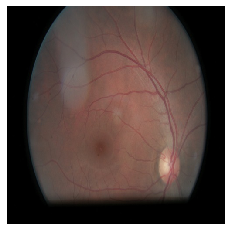

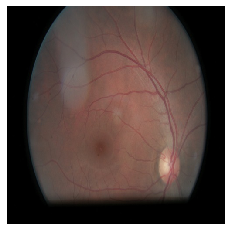

(500, 500)


In [38]:
confusion_matrix_object = np.zeros((5,5))

filenames = validation_generator.filenames
#filenames = train_generator.filenames
folder = 'val'
#folder = 'train'

correct = 0
total = len(filenames)
image_dir = 'data/' + folder + '/' + filenames[0]
result = load_image(image_dir, show=True, verbose = True)


new_image = image.load_img(image_dir)
plt.imshow(new_image)                           
plt.axis('off')
plt.show()
print(new_image.size)

In [39]:

for image_name in filenames:

  image_object = 'data/' + folder + '/' + image_name
  #print(image_object)
  class_name = image_object.split('/')[2]
  true_class = int(class_name[-1])

  result =  model1.predict(load_image(image_object))[0].tolist()
  result = int(result.index(max(result)))

  if true_class == result:
    correct = correct + 1

  confusion_matrix_object[true_class, result] = 1 + confusion_matrix_object[true_class, result]

print('Overall Accuracy:', correct/total, '\n')

print('Confusion Matrix: rows is true, columns is result \n', confusion_matrix_object)

Overall Accuracy: 0.2577464788732394 

Confusion Matrix: rows is true, columns is result 
 [[64.  3. 54. 14.  7.]
 [62.  4. 48. 21.  7.]
 [47.  7. 59. 18. 11.]
 [46.  0. 56. 26. 14.]
 [35.  5. 47. 25. 30.]]


In [40]:
import sys
for x in range (0, 5):

  row_total = sum(confusion_matrix_object[x])
  if row_total != 142:
    raise Exception('Error, row_total is {} instead of 142'.format(int(row_total)))

  print('Accuracy for class', x, 'is', confusion_matrix_object[x][x]/row_total)

Accuracy for class 0 is 0.4507042253521127
Accuracy for class 1 is 0.028169014084507043
Accuracy for class 2 is 0.4154929577464789
Accuracy for class 3 is 0.18309859154929578
Accuracy for class 4 is 0.2112676056338028


# Logistic Regression

In [ ]:
# https://medium.com/@luwei.io/logistic-regression-with-keras-d75d640d175e
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

"""
Prepare you data, such as:
"""
#x_train = np.array([],[],[])  # should be a numpy array
#y_train = np.array([],[],[])  # should be a numpy array
#x_val = np.array([],[],[])    # should be a numpy array
#y_val = np.array([],[],[])    # should be a numpy array


"""
Set up the logistic regression model
"""
model = Sequential()
model.add(Dense(2,  # output dim is 2, one score per each class
                activation='softmax',
                kernel_regularizer=L1L2(l1=0.0, l2=0.1),
                input_dim=len(feature_vector))  # input dimension = number of features your data has
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train=train_generator,
          y_train,
          epochs=100,
          #validation_data=(x_val, y_val)
          validation_data=validation_generation
         )
          
          
          
          
          
          